In [124]:
tbo_vals = pd.read_csv('/nfs/a319/gy17m2a/PhD/datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')
tbo_vals

,Station_id,Station_name,Lon,Lat,Critical_interarrival_time
0,EA000008,harley_logger,-1.441003,53.480547,7.50
1,EA000076TP,prestwood_reservoir_tbr,-0.747444,51.701009,9.00
2,EA000102TP,elsenham_g.c,0.245191,51.915371,9.50
3,EA000180TP,havering_bower,0.168787,51.619601,12.50
4,EA000181TP,nazeing_g.c,0.040314,51.728627,10.50
...,...,...,...,...,...
1289,SEPA504458,kirkcudbright,-4.037240,54.845340,5.75
1290,SEPA506152,unthank,-2.962650,55.242860,3.50
1291,SEPA515885,kirkwall,-2.899880,58.953870,8.75
1292,SEPA517412,balfron_stw,-4.343600,56.067710,4.25


In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import os
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt    
import re

from Analyse_Events_Functions import *

def find_quintile_with_max_value(intensities):
    
    # Number of elements in each quintile
    quintile_size = len(intensities) // 5
    
    # Calculate the indices that will split the array into quintiles
    quintile_indices = [i * quintile_size for i in range(1, 5)] + [len(intensities)]
    
    # Split the array into quintiles
    quintiles = np.array_split(intensities, 5)
    
    # Find the quintile that contains the maximum value
    max_value = np.max(intensities)
    for i, quintile in enumerate(quintiles):
        if max_value in quintile:
            return i
        
def check_for_nan(profiles_list, durations_list):
    new_profiles_list =[]
    new_durations_list =[]
    for i, profile in enumerate(profiles_list):
        if np.isnan(profile).any():
            print(f"NaN values found in profile {i}")
        else:
            new_profiles_list.append(profile)
            new_durations_list.append(durations_list[i])
    return new_profiles_list, new_durations_list


def interpolate_and_bin(normalized_time, normalized_rainfall):
    """
    Interpolate missing data points and bin the dimensionless profile into 12 segments.
    
    Parameters:
        normalized_time (np.array): Normalized time array.
        normalized_rainfall (np.array): Normalized cumulative rainfall array.
    
    Returns:
        np.array: Binned and interpolated rainfall profile.
    """
    # Define target points for 12 bins
    target_points = np.linspace(0, 1, 13)
    
    # Create interpolation function based on existing data points
    interpolation_func = interp1d(normalized_time, normalized_rainfall, kind='linear', fill_value="extrapolate")
    
    # Interpolate values at target points
    interpolated_values = interpolation_func(target_points)
    
    return interpolated_values

# Create a set of dimensionless profiles
Read in all of the events, for all durations, for all gauges, for all ensemble members.  
Convert them to dimensionless profiles, with 12 values between 0 and 1.  
Each value is a dimensionless, cumulative rainfall value (cumulative rainfall at this timestep, normalised by the total event rainfall):
- 0 means no rainfall has occurred, and 
- 1 means the total event rainfall has been reached.  

If there are less than 12 values, then these are filled in with interpolation

# Generate summary profiles
Run cluster analysis on the profiles to identify clusters of events with similar profiles.  
This is performed on the cumulative, normalised rainfall profiles.  
The objective is to group similar rainfall events based on how rainfall accumulates over time (regardless of individual intensities or durations).  
The output of this is centroids which represent the average cumulative profile of each cluster.   

In [110]:
gauge_nums = list(range(0,25))
gauge_nums.extend(list(range(50,54)))

In [112]:
nimrod_profiles_unfiltered = []
nimrod_profiles_filtered100 = []
nimrod_profiles_filtered300 = []

durations_for_nimrod_profiles_unfiltered = []
durations_for_nimrod_profiles_filtered100 = []
durations_for_nimrod_profiles_filtered300 = []

nimrod_profiles_ls = [nimrod_profiles_unfiltered, nimrod_profiles_filtered100, nimrod_profiles_filtered300]
durations_for_nimrod_profiles_ls = [durations_for_nimrod_profiles_unfiltered, durations_for_nimrod_profiles_filtered100, durations_for_nimrod_profiles_filtered300]

for number, folder in enumerate(['NIMROD_1km_unfiltered', 'NIMROD_1km_filtered_100', "NIMROD_1km_filtered_300"]):

    for gauge_num in gauge_nums:
        # Create a list of all the event CSVs
        files = [f for f in os.listdir(f"../../ProcessedData/IndependentEvents/NIMROD/{folder}/{gauge_num}/") if f.endswith('.csv')]
        files = np.sort(files)

        # For each event
        for num, file in enumerate(files):
            test = pd.read_csv(f"../../ProcessedData/IndependentEvents/NIMROD/{folder}/{gauge_num}/{file}")
            # find duration from file name
            pattern = re.compile(r'(\d+\.?\d*)hrs')
            match = pattern.search(file)
            duration = match.group(1)

            if len(test)==1:
                print(f"Only 1 value at gauge_num {gauge_num} for {file}")
            else:
                times = np.array(range(0,len(test)))
                normalized_time, normalized_rainfall = create_dimensionless_profile(times, np.array(test['precipitation (mm/hr)']))
                interpolated_rainfall = interpolate_and_bin(normalized_time, normalized_rainfall)
                nimrod_profiles_ls[number].append(interpolated_rainfall) 
                heaviest_segment = categorize_normalized_rainstorm(interpolated_rainfall)

                durations_for_nimrod_profiles_ls[number].append(duration)

In [113]:
nimrod_profiles_filtered300_nonans, durations_for_nimrod_profiles_filtered300_nonans = check_for_nan(nimrod_profiles_filtered300, durations_for_nimrod_profiles_filtered300)
nimrod_profiles_filtered100_nonans, durations_for_nimrod_profiles_filtered100_nonans = check_for_nan(nimrod_profiles_filtered100, durations_for_nimrod_profiles_filtered100)
nimrod_profiles_unfiltered_nonans, durations_for_nimrod_profiles_unfiltered_nonans = check_for_nan(nimrod_profiles_unfiltered, durations_for_nimrod_profiles_unfiltered)

NaN values found in profile 232
NaN values found in profile 247
NaN values found in profile 263
NaN values found in profile 279
NaN values found in profile 295
NaN values found in profile 310
NaN values found in profile 325
NaN values found in profile 2332
NaN values found in profile 119
NaN values found in profile 229
NaN values found in profile 244
NaN values found in profile 260
NaN values found in profile 276
NaN values found in profile 292
NaN values found in profile 307
NaN values found in profile 322
NaN values found in profile 550
NaN values found in profile 565
NaN values found in profile 566
NaN values found in profile 581
NaN values found in profile 620
NaN values found in profile 635
NaN values found in profile 640
NaN values found in profile 650
NaN values found in profile 655
NaN values found in profile 1545
NaN values found in profile 1571
NaN values found in profile 1584
NaN values found in profile 1585
NaN values found in profile 1610
NaN values found in profile 1622
N

In [114]:
nimrod_profiles_ls = [nimrod_profiles_unfiltered_nonans, nimrod_profiles_filtered100_nonans, nimrod_profiles_filtered300_nonans]
durations_for_nimrod_profiles_ls = [durations_for_nimrod_profiles_unfiltered_nonans, durations_for_nimrod_profiles_filtered100_nonans, durations_for_nimrod_profiles_filtered300_nonans]

## Classify and plot dimensionless profiles

### Convert cumulative rainfall data into intensity profiles
This is to better illustrate the characteristic behaviours/patterns revealed by clusters.  

This involves:  
- Converting cumulative rainfall to intensities (differentiating the cumulative rainfall with respect to time to obtain instantaneous rainfall intensities?)
- Normalising these intensities by a characteristic intensity, often the average intensity of each profile or the peak intensity.

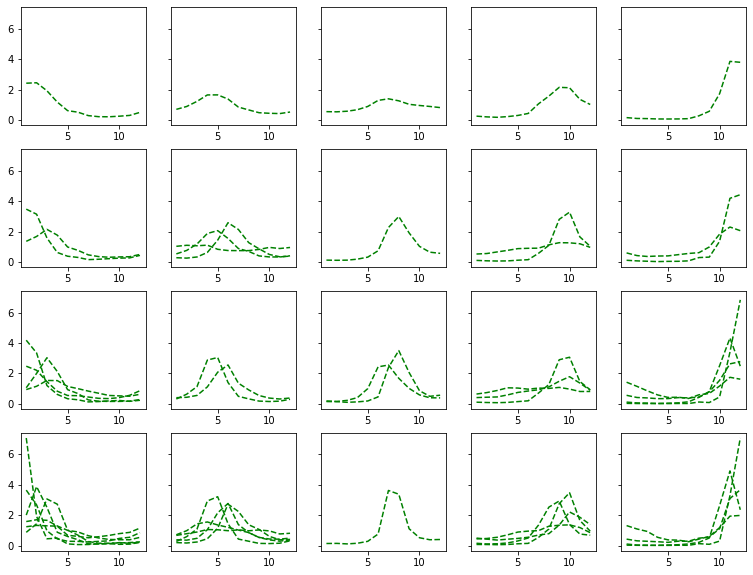

In [115]:
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(13,10), sharey=True)

color = colours[number]
linestyle=linestyles[number]
durations_for_profiles = durations_for_nimrod_profiles_filtered300_nonans
# durations_for_profiles = durations_for_nimrod_profiles_unfiltered_nonans
profiles = nimrod_profiles_filtered300_nonans
# profiles = nimrod_profiles_unfiltered_nonans
for num_clusters in [5,10,15,20]:
    # Create and fit the model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(profiles)

    # Get cluster labels for each profile
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    df= pd.DataFrame({'cluster_num':labels, 'duration':durations_for_profiles})
    df['duration'] =  pd.to_numeric(df['duration'])
    df.groupby('cluster_num')['duration'].mean()

    for num, centroid_cumulative in enumerate(centroids):

        # Find portion which is heaviest
        heaviest_segment=categorize_normalized_rainstorm(centroid_cumulative)

        # Convert to intensity
        time_hours = np.array(range(0,len(centroid_cumulative)))  # Time in hours

        # Convert cumulative to intensity (mm/hour)
        intensity = np.diff(centroid_cumulative) / np.diff(time_hours)

        quintile_with_max_value = find_quintile_with_max_value(intensity)

        # Calculate average intensity
        average_intensity = np.sum(intensity) / (time_hours[-1] - time_hours[1])

        # Normalize intensity by average intensity
        normalized_intensity = intensity / average_intensity


        if num_clusters ==5 :
            axs[0, quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                  color=color, linestyle=linestyle)
        elif num_clusters ==10:
            axs[1,quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                  color=color, linestyle=linestyle)
        elif num_clusters ==15:
            axs[2,quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                  color=color, linestyle=linestyle) 
        else:
            axs[3,quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                  color=color, linestyle=linestyle)  


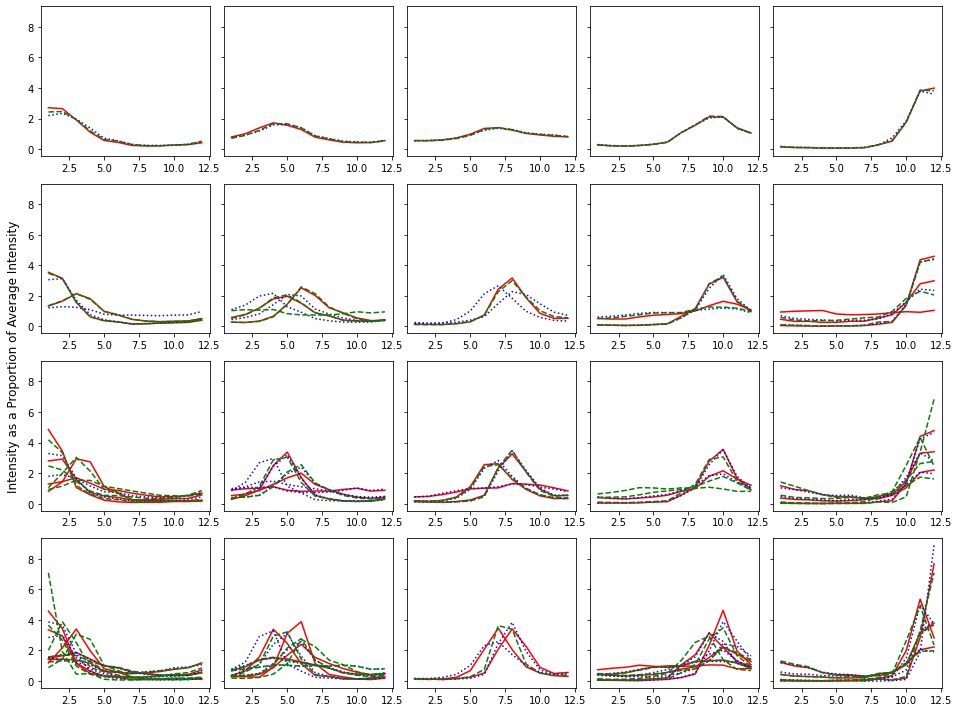

In [116]:
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(13,10), sharey=True)

# Assuming `profiles` is your array where rows are the dimensionless profiles

durations_for_profiles_ls = durations_for_nimrod_profiles_ls
linestyles =['solid', 'dotted', 'dashed']
colours = ['red','blue','green']
for number, profiles in enumerate(nimrod_profiles_ls):
    color = colours[number]
    linestyle=linestyles[number]
    durations_for_profiles = durations_for_profiles_ls[number]
    for num_clusters in [5,10,15,20]:
        # Create and fit the model
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(profiles)

        # Get cluster labels for each profile
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_

        df= pd.DataFrame({'cluster_num':labels, 'duration':durations_for_profiles})
        df['duration'] =  pd.to_numeric(df['duration'])
        df.groupby('cluster_num')['duration'].mean()

        for num, centroid_cumulative in enumerate(centroids):

            # Find portion which is heaviest
            heaviest_segment=categorize_normalized_rainstorm(centroid_cumulative)

            # Convert to intensity
            time_hours = np.array(range(0,len(centroid_cumulative)))  # Time in hours

            # Convert cumulative to intensity (mm/hour)
            intensity = np.diff(centroid_cumulative) / np.diff(time_hours)
            
            quintile_with_max_value = find_quintile_with_max_value(intensity)

            # Calculate average intensity
            average_intensity = np.sum(intensity) / (time_hours[-1] - time_hours[1])

            # Normalize intensity by average intensity
            normalized_intensity = intensity / average_intensity


            if num_clusters ==5 :
                axs[0, quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                      color=color, linestyle=linestyle)
            elif num_clusters ==10:
                axs[1,quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                      color=color, linestyle=linestyle)
            elif num_clusters ==15:
                axs[2,quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                      color=color, linestyle=linestyle) 
            else:
                axs[3,quintile_with_max_value].plot(time_hours[1:], normalized_intensity,
                                      color=color, linestyle=linestyle)  

    # Adjust the layout
fig.tight_layout()
fig.supylabel('Intensity as a Proportion of Average Intensity', x=- 0.01)
plt.show()

### Compare to the RVH profiles

In [87]:
# Read in profiles
rvh_profiles = pd.read_csv("../CatchmentAnalysis/CreateSyntheticRainfallEvents/ObservedProfiles/kmeans_15clustersPerDur.csv")
# Just keep prain (proportion of rainfall in each timestep)
rvh_profiles = rvh_profiles[rvh_profiles['Variable'] == 'prain']
rvh_profiles = rvh_profiles[rvh_profiles['Duration'] == '[2:10 - 6:45) hr']
np.array(cluster1['Mean'])

array([], dtype=float64)

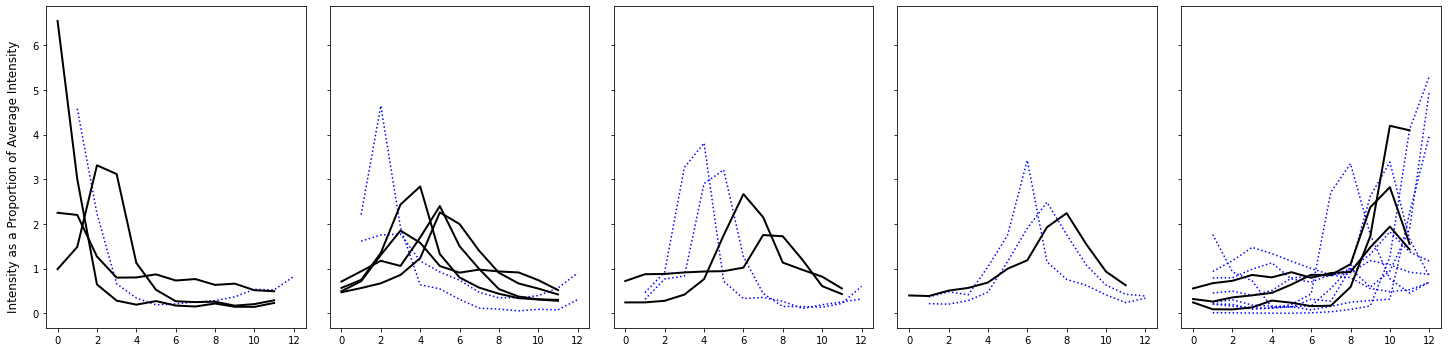

In [96]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20,5), sharey=True)

# Assuming `profiles` is your array where rows are the dimensionless profiles
num_clusters=15

# Create and fit the model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(profiles)

# Get cluster labels for each profile
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

df= pd.DataFrame({'cluster_num':labels, 'duration':durations_for_profiles})
df['duration'] =  pd.to_numeric(df['duration'])
df.groupby('cluster_num')['duration'].mean()

for num, centroid_cumulative in enumerate(centroids):

    # Find portion which is heaviest
    heaviest_segment=categorize_normalized_rainstorm(centroid_cumulative)

    # Convert to intensity
    time_hours = np.array(range(0,len(centroid_cumulative)))  # Time in hours

    # Convert cumulative to intensity (mm/hour)
    intensity = np.diff(centroid_cumulative) / np.diff(time_hours)

    # Calculate average intensity
    average_intensity = np.sum(intensity) / (time_hours[-1] - time_hours[1])

    # Normalize intensity by average intensity
    normalized_intensity = intensity / average_intensity

    # plot
    axs[heaviest_segment].plot(time_hours[1:], normalized_intensity,
                              color='blue', linestyle='dotted') 

for cluster_num in range(1,14):
    cluster1=rvh_profiles[rvh_profiles['Cluster']==cluster_num]
    cluster1 = cluster1[:-2]
    #cluster1 = cluster1[~cluster1['Dur_bins'].isin([0,1])]
    quintile_with_max_value = find_quintile_with_max_value(np.array(cluster1['Mean']))
#     heaviest_segment=categorize_normalized_rainstorm(np.array(cluster1['Mean']))
    axs[quintile_with_max_value].plot(range(len(cluster1)),cluster1['Mean'], linewidth = 2, color='black')   
    
    
# Adjust the layout
fig.tight_layout()
fig.supylabel('Intensity as a Proportion of Average Intensity', x=- 0.01)
plt.show()

In [10]:
for i in range(0,len(profiles)):
    print(i, profiles[i])

0 [0.0177634  0.17305435 0.32834531 0.48363626 0.63892722 0.69378757
 0.74864792 0.80350827 0.85836863 0.89377647 0.92918431 0.96459216
 1.        ]
1 [0.01177138 0.10608608 0.22691677 0.32273467 0.40188475 0.52188647
 0.62893636 0.66297388 0.66393548 0.66393548 0.66656608 0.91473765
 1.        ]
2 [0.00702713 0.45617802 0.4583252  0.54538357 0.80675386 0.80714426
 0.80714426 0.80714426 0.81898628 0.84276791 0.89052639 0.92125382
 1.        ]
3 [0.0153349  0.05033591 0.12470562 0.22957172 0.36236012 0.62467368
 0.72104168 0.81002976 0.88374683 0.93337532 0.96338792 0.98204995
 1.        ]
4 [0.01089638 0.12760417 0.24431195 0.36101974 0.47772752 0.59443531
 0.71114309 0.75928591 0.80742873 0.85557155 0.90371436 0.95185718
 1.        ]
5 [0.03769285 0.04628331 0.0743338  0.0743338  0.16403693 0.35448808
 0.70213885 0.76747312 0.79242637 0.79654628 0.80592567 0.80601332
 1.        ]
6 [7.03915566e-04 4.37901451e-01 4.50241970e-01 4.50241970e-01
 4.50241970e-01 4.62450505e-01 4.87417509e-

 1.        ]
359 [0.00819314 0.01966353 0.14725803 0.30773432 0.37557352 0.56936858
 0.6698711  0.70002185 0.70548395 0.70548395 0.88245576 0.94974874
 1.        ]
360 [0.04073261 0.16916277 0.22951445 0.22951445 0.22951445 0.30347546
 0.88705524 0.88905848 0.90966327 0.91977488 0.94419537 0.94527648
 1.        ]
361 [1.20001926e-04 7.44811913e-02 4.15646644e-01 7.51182016e-01
 8.71533942e-01 8.87634199e-01 8.95634328e-01 9.06334500e-01
 9.11102576e-01 9.11978590e-01 9.14318628e-01 9.28058848e-01
 1.00000000e+00]
362 [0.0213585  0.07607931 0.11337389 0.13324227 0.15046152 0.17496585
 0.20675524 0.28887784 0.45713812 0.71153608 0.8598038  0.95595844
 1.        ]
363 [0.02156543 0.14291033 0.14734943 0.14752126 0.1476931  0.14976945
 0.18180256 0.34461723 0.35495604 0.38229229 0.47635822 0.74266117
 1.        ]
364 [0.02536232 0.16711957 0.33278986 0.48596015 0.58478262 0.74402175
 0.81702899 0.8446558  0.85072464 0.85778986 0.86050725 0.86050725
 1.        ]
365 [0.02417274 0.07414644 0

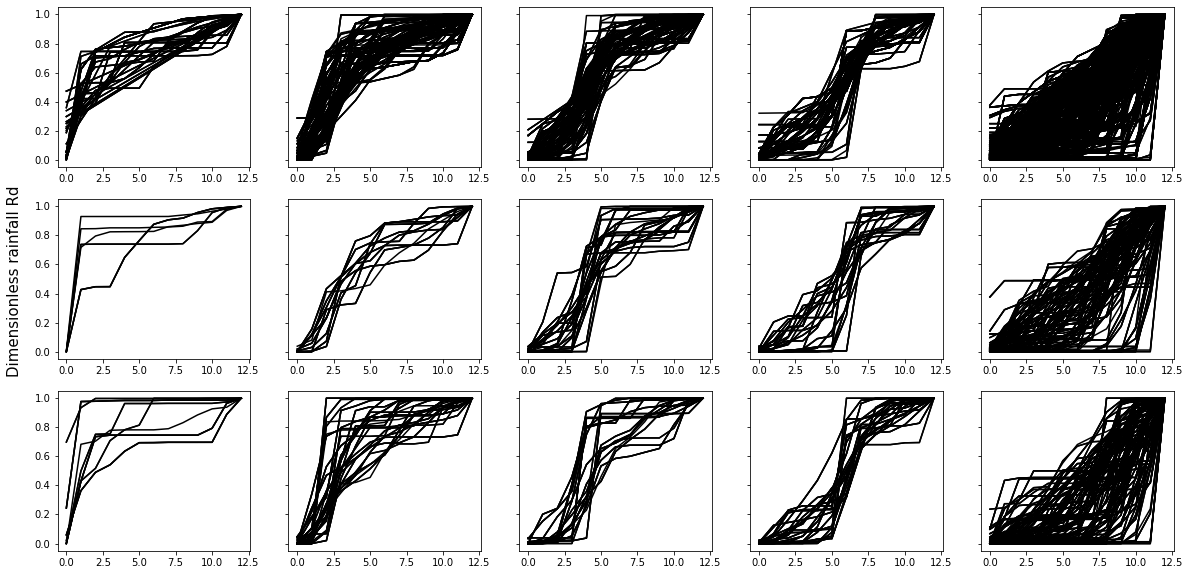

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

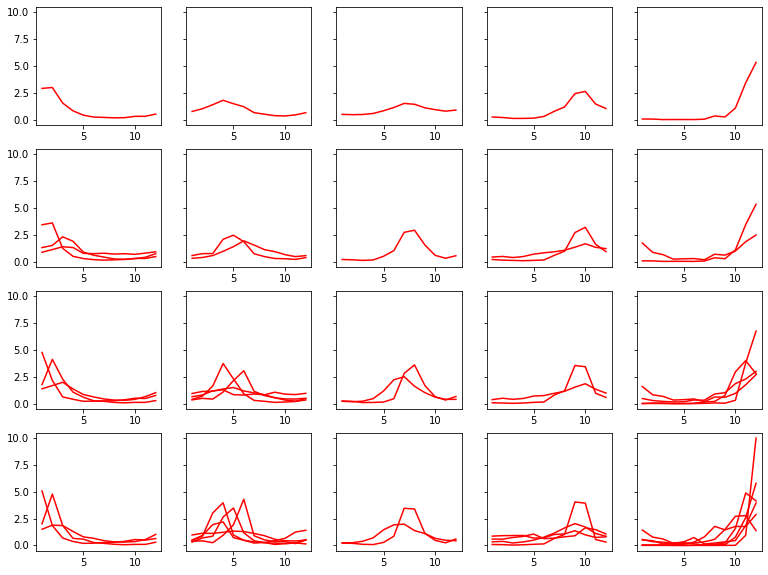

In [5]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define your helper functions (create_dimensionless_profile, interpolate_and_bin, categorize_normalized_rainstorm, find_quintile_with_max_value) here

# Function to process profiles for a specific dataset
def process_nimrod_profiles(dataset_name, gauge_num_range, axs):
    profiles = []
    durations = []
    
    for gauge_num in gauge_num_range:
        # Create a list of all the event CSVs
        files = [f for f in os.listdir(f"../../ProcessedData/IndependentEvents/NIMROD/NIMROD_1km_{dataset_name}/{gauge_num}/") if f.endswith('.csv')]
        files = np.sort(files)

        # For each event
        for num, file in enumerate(files):
            test = pd.read_csv(f"../../ProcessedData/IndependentEvents/NIMROD/NIMROD_1km_{dataset_name}/{gauge_num}/{file}")
            # Find duration from file name
            pattern = re.compile(r'(\d+\.?\d*)hrs')
            match = pattern.search(file)
            duration = match.group(1)

            if len(test) == 1:
                print(f"Only 1 value at gauge_num {gauge_num} for {file}")
            else:
                times = np.array(range(0, len(test)))
                normalized_time, normalized_rainfall = create_dimensionless_profile(times, np.array(test['precipitation (mm/hr)']))
                interpolated_rainfall = interpolate_and_bin(normalized_time, normalized_rainfall)
                profiles.append(interpolated_rainfall)
                heaviest_segment = categorize_normalized_rainstorm(interpolated_rainfall)

                if duration in ['0.5', '1', '2', '3', '6']:
                    axs[0, heaviest_segment].plot(interpolated_rainfall, label=f'Profile with heaviest in segment {heaviest_segment + 1}', color='black')
                elif duration in ['12']:
                    axs[1, heaviest_segment].plot(interpolated_rainfall, label=f'Profile with heaviest in segment {heaviest_segment + 1}', color='black')
                else:
                    axs[2, heaviest_segment].plot(interpolated_rainfall, label=f'Profile with heaviest in segment {heaviest_segment + 1}', color='black')
                durations.append(duration)

    return profiles, durations

# Initialize plots
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20, 10), sharey=True)

# Process profiles for each dataset
nimrod_profiles = []
durations_for_nimrod_profiles = []
datasets = ['unfiltered', 'filtered_100', 'filtered_300']

for dataset in datasets:
    profiles, durations = process_nimrod_profiles(dataset, range(0, 10), axs)
    nimrod_profiles.append(profiles)
    durations_for_nimrod_profiles.append(durations)

fig.supylabel('Dimensionless rainfall Rd', x=0.09, fontsize=15)
plt.show()

# Now cluster and plot the normalized intensity profiles
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(13, 10), sharey=True)

# Assuming each dataset has its own color and linestyle
linestyles = ['solid', 'dotted', 'dashed']
colours = ['red', 'blue', 'green']

for dataset_idx, profiles in enumerate(nimrod_profiles):
    color = colours[dataset_idx]
    linestyle = linestyles[dataset_idx]
    durations_for_profiles = durations_for_nimrod_profiles[dataset_idx]
    for num_clusters in [5, 10, 15, 20]:
        # Create and fit the model
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(profiles)

        # Get cluster labels for each profile
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_

        df = pd.DataFrame({'cluster_num': labels, 'duration': durations_for_profiles})
        df['duration'] = pd.to_numeric(df['duration'])
        df.groupby('cluster_num')['duration'].mean()

        for num, centroid_cumulative in enumerate(centroids):
            # Find portion which is heaviest
            heaviest_segment = categorize_normalized_rainstorm(centroid_cumulative)

            # Convert to intensity
            time_hours = np.array(range(0, len(centroid_cumulative)))  # Time in hours

            # Convert cumulative to intensity (mm/hour)
            intensity = np.diff(centroid_cumulative) / np.diff(time_hours)

            quintile_with_max_value = find_quintile_with_max_value(intensity)

            # Calculate average intensity
            average_intensity = np.sum(intensity) / (time_hours[-1] - time_hours[1])

            # Normalize intensity by average intensity
            normalized_intensity = intensity / average_intensity

            if num_clusters == 5:
                axs[0, quintile_with_max_value].plot(time_hours[1:], normalized_intensity, color=color, linestyle=linestyle)
            elif num_clusters == 10:
                axs[1, quintile_with_max_value].plot(time_hours[1:], normalized_intensity, color=color, linestyle=linestyle)
            elif num_clusters == 15:
                axs[2, quintile_with_max_value].plot(time_hours[1:], normalized_intensity, color=color, linestyle=linestyle)
            else:
                axs[3, quintile_with_max_value].plot(time_hours[1:], normalized_intensity, color=color, linestyle=linestyle)

# Adjust the layout
fig.tight_layout()
fig.supylabel('Intensity as a Proportion of Average Intensity', x=-0.01)
plt.show()
